In [3]:
### In this approach, we will first remove outliers (point that has large
### distance from local density)
### Reference for this approach: Kaggle (Dr.FraNKeNSTeiN)

In [124]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from scipy.stats import randint
import xgboost as xgb
import matplotlib.pyplot as plt

In [51]:
df = pd.read_csv("loan-train.csv")

In [52]:
df=df.dropna()
df=df.drop('Loan_ID',axis=1)

In [7]:
# Before we remove outliers, let's assign numerical values to our categorical data

In [53]:
Gender_code = {'Male': 0, 'Female':1}
Married_code = {'Yes':1, 'No':0}
Education_code = {'Graduate':1, 'Not Graduate':0}
Self_Employed_code = {'Yes':1,'No':0}
Dependents_code = {"0":0,"1":1,'2':2,"3+":3}
Loan_Status_code ={"Y":1, "N":0}
Rural_code = {"Rural":1, 'Urban':0, 'Semiurban':0}
Urban_code = {"Rural":0, 'Urban':1, 'Semiurban':0}
Semiurban_code = {"Rural":0, 'Urban':0, 'Semiurban':1}

In [54]:
df['Gender'] = df.Gender.map(Gender_code)
df['Married'] = df.Married.map(Married_code)
df['Education'] = df.Education.map(Education_code)
df['Self_Employed'] = df.Self_Employed.map(Self_Employed_code)
df['Dependents'] = df.Dependents.map(Dependents_code)
df['Loan_Status'] = df.Loan_Status.map(Loan_Status_code)
df['Rural_Region'] = df.Property_Area.map(Rural_code)
df['Urban_Region'] = df.Property_Area.map(Urban_code)
df['Semiurban_Region'] = df.Property_Area.map(Semiurban_code)
df=df.drop('Property_Area',axis=1)

In [59]:
# Now let's work on removing outliers

In [60]:
out_factor = LocalOutlierFactor(n_neighbors = 20, contamination=0.1)

In [61]:
out_factor.fit(df)

LocalOutlierFactor(contamination=0.1)

In [112]:
out_score = out_factor.negative_outlier_factor_

In [69]:
thresh_val = np.sort(out_score)[14]
df_cleaned = df[out_score >= thresh_val]

In [72]:
X = df_cleaned.drop('Loan_Status',axis=1)
y = df_cleaned['Loan_Status']

In [74]:
## Now we are ready to normalize our dataset

In [79]:
X = (X-np.min(X)) / (np.max(X)-np.min(X)).values

In [80]:
## Let's now split the data

In [82]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [83]:
#1. Logistic Regression

In [115]:
lg = LogisticRegression(solver='liblinear')
lg.fit(X_train,y_train)
y_pred = lg.predict(X_test)
lg_accuracy = accuracy_score(y_test,y_pred)
print(str(round(lg_accuracy*100,2))+"%")

90.43%


In [ ]:
#2. Random Forest

In [116]:
rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 50)
rfc.fit(X_train, y_train)
y_pred1 = rfc.predict(X_test)
rfc_accuracy = accuracy_score(y_test,y_pred1)
print(str(round(rfc_accuracy*100,2))+"%")

80.85%


Text(0.5, 0, 'Level of Significance')

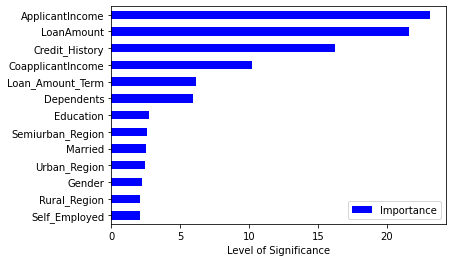

In [131]:
importance = pd.DataFrame({"Importance": rfc.feature_importances_*100},
                         index = X_train.columns)
importance.sort_values(by='Importance',axis=0,ascending=True).plot(kind='barh',color='blue')
plt.xlabel('Level of Significance')

In [92]:
est = RandomForestClassifier(n_jobs=-1)
rf_p_dist={'max_depth':[3,5,10,None],
          'n_estimators':[100,200,300,400,500],
           'max_features':randint(1,11),
           'criterion':['gini','entropy'],
           'bootstrap':[True,False],
           'min_samples_leaf':randint(1,4),
          }

def hypertuning_rscv(est, p_distr, nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,
                              n_jobs=-1, n_iter=nbr_iter, cv=9)
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return ht_params, ht_score

In [95]:
rf_parameters, rf_ht_score = hypertuning_rscv(est, rf_p_dist, 40, X, y)

In [96]:
rf_parameters

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 5,
 'min_samples_leaf': 1,
 'n_estimators': 200}

In [117]:
rfc2 = RandomForestClassifier(bootstrap=False,n_estimators = 200, criterion = 'gini', max_depth=5, max_features = 5, min_samples_leaf=1,random_state = 50)
rfc2.fit(X_train, y_train)
y_pred2 = rfc2.predict(X_test)
rfc2_accuracy = accuracy_score(y_test,y_pred2)
print(str(round(rfc2_accuracy*100,2))+"%")

87.23%


Text(0.5, 0, 'Level of Significance')

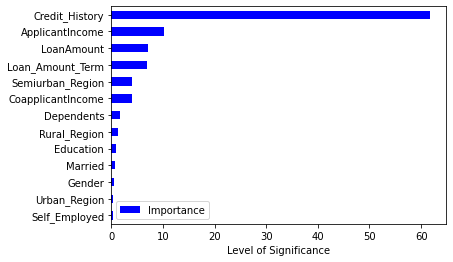

In [126]:
importance = pd.DataFrame({"Importance": rfc2.feature_importances_*100},
                         index = X_train.columns)
importance.sort_values(by='Importance',axis=0,ascending=True).plot(kind='barh',color='blue')
plt.xlabel('Level of Significance')

In [ ]:
#3. ADABoost

In [118]:
ada = AdaBoostClassifier(n_estimators=300, random_state=42, learning_rate=.01)
ada.fit(X_train, y_train)
y_pred3 = ada.predict(X_test)
ada_accuracy = accuracy_score(y_test,y_pred3)
print(str(round(ada_accuracy*100,2))+"%")

89.36%


Text(0.5, 0, 'Level of Significance')

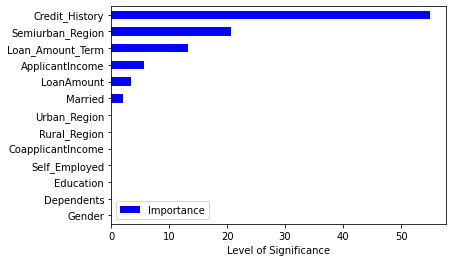

In [127]:
importance = pd.DataFrame({"Importance": ada.feature_importances_*100},
                         index = X_train.columns)
importance.sort_values(by='Importance',axis=0,ascending=True).plot(kind='barh',color='blue')
plt.xlabel('Level of Significance')

In [ ]:
#4.Gradient Boost

In [119]:
gbc = GradientBoostingClassifier(n_estimators=300, random_state=42, learning_rate=.01)
gbc.fit(X_train,y_train)
y_pred4 = gbc.predict(X_test)
gbc_accuracy = accuracy_score(y_test,y_pred4)
print(str(round(gbc_accuracy*100,2))+"%")

88.3%


Text(0.5, 0, 'Level of Significance')

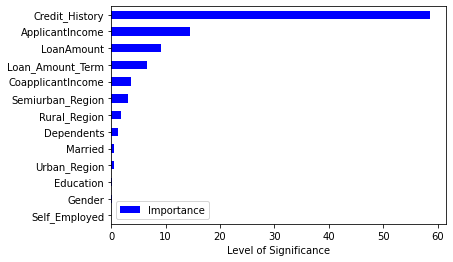

In [129]:
importance = pd.DataFrame({"Importance": gbc.feature_importances_*100},
                         index = X_train.columns)
importance.sort_values(by='Importance',axis=0,ascending=True).plot(kind='barh',color='blue')
plt.xlabel('Level of Significance')

In [ ]:
#5. XGBoost

In [120]:
xgc = xgb.XGBClassifier(n_estimators=300, random_state=42, learning_rate=.01)
xgc.fit(X_train,y_train)
y_pred5 = xgc.predict(X_test)
xgc_accuracy = accuracy_score(y_test,y_pred5)
print(str(round(xgc_accuracy*100,2))+"%")

C:\Users\Andrew\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:25:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
90.43%


Text(0.5, 0, 'Level of Significance')

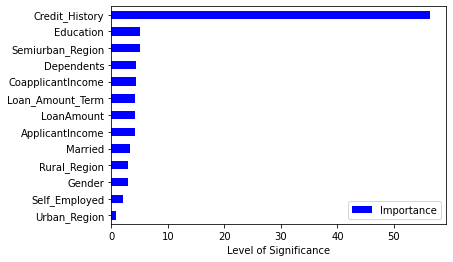

In [132]:
importance = pd.DataFrame({"Importance": xgc.feature_importances_*100},
                         index = X_train.columns)
importance.sort_values(by='Importance',axis=0,ascending=True).plot(kind='barh',color='blue')
plt.xlabel('Level of Significance')

In [133]:
xgc.feature_importances_*100

array([ 2.9373448,  3.3156817,  4.3799734,  5.1131105,  2.0539527,
        4.1683683,  4.319152 ,  4.2194257,  4.223402 , 56.3653   ,
        2.9948196,  0.8095975,  5.0998697], dtype=float32)